In [1]:
# fecthing and saving data

import os
import urllib.request

DOWNLOAD_ROOT = "https://archive.ics.uci.edu/ml/"
ECHOCARDIOGRAM_URL = DOWNLOAD_ROOT + "machine-learning-databases/echocardiogram/echocardiogram.data"
cwd = os.getcwd()
ECHOCARDIOGRAM_PATH = os.path.join(cwd,"datasets","echocardiogram")

def fetch_echocardiogram_data(echocardiogram_url=ECHOCARDIOGRAM_URL, echocardiogram_path=ECHOCARDIOGRAM_PATH):
    echocardiogram_data_path=os.path.join(echocardiogram_path,"echocardiogram.data")
    os.makedirs(echocardiogram_path, exist_ok=True)
    urllib.request.urlretrieve(echocardiogram_url,echocardiogram_data_path)

fetch_echocardiogram_data()

In [2]:
# loading data

import pandas as pd 

pd.set_option("display.max_rows", None)

def load_echocardiogram_data(echocardiogram_path=ECHOCARDIOGRAM_PATH):
        echocardiogram_data_path=os.path.join(echocardiogram_path,"echocardiogram.data")
        return pd.read_csv(echocardiogram_data_path,names=["survival","still-alive","age-at-heart-attack","pericardial-effusion","fractional-shortening","epss","lvdd","wall-motion-score","wall-motion-index","mult","name","group","alive-at-1"], header=None)
    
echocardiogram_data=load_echocardiogram_data()

In [3]:
# prepare data

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# replace '?' with None to indicate missing values

echocardiogram_data.replace({'?': None},inplace =True)

# drop instances with missing survival attribute

echocardiogram_data.dropna(subset=["survival","still-alive"],inplace=True)

# drop instances with survival less than 12 months and still-alive equal to 1

echocardiogram_data["survival"]= pd.to_numeric(echocardiogram_data["survival"])
echocardiogram_data["still-alive"]= pd.to_numeric(echocardiogram_data["still-alive"])
echocardiogram_data=echocardiogram_data[~((echocardiogram_data["survival"]<12) & (echocardiogram_data["still-alive"]==1))]

# replacing missing values in alive-at-1 column

def compute_still_alive_at_1(survival):
    if survival >= 12.0:
        return 1
    else:
        return 0

echocardiogram_data["alive-at-1"] = echocardiogram_data["survival"].apply(compute_still_alive_at_1)

#echocardiogram_data

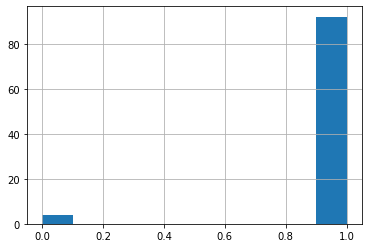

In [4]:
# histogram for label column shows that dataset is very imbalanced

echocardiogram_data["alive-at-1"].hist()

In [5]:
#spliting data into train and test sets

# split into X and y, drop irrelevant features: mult, name, group

echocardiogram_features=["age-at-heart-attack","pericardial-effusion","fractional-shortening","epss","lvdd","wall-motion-score","wall-motion-index"]
X=echocardiogram_data[echocardiogram_features]
y=echocardiogram_data["alive-at-1"]

# split data into train and test sets

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# preprocessing numerical data

numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler',StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, echocardiogram_features),
    ])

train_X_prepared = preprocessor.fit_transform(train_X)

In [7]:
# grid search

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = [
    {"kernel": ["linear", "poly", "rbf", "sigmoid"], "C": [2, 4, 6, 8,50,100]},
]

svc_classifier = SVC()

grid_search = GridSearchCV(svc_classifier, param_grid, cv=5, scoring='roc_auc')

grid_search.fit(train_X_prepared, train_y)

/home/daniel/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [ ]:
# ROC AUC for test set

from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score

model = grid_search.best_estimator_

test_X_prepared = preprocessor.transform(test_X)

test_y_scores = model.decision_function(test_X_prepared)

fpr, tpr, thresholds = roc_curve(test_y, test_y_scores)

plt.plot(fpr, tpr, linewidth=2)
plt.show()

roc_auc_score(test_y, test_y_scores)

In [ ]:
# confusion matrix

from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model,test_X_prepared, test_y)  
plt.show()